# Practice: REINFORCE in PyTorch
__This notebook is based on [Practical_RL week06](https://github.com/yandexdataschool/Practical_RL/tree/master/week06_policy_based) materials__

Just like we did before for q-learning, this time we'll design a pytorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Starting virtual X frame buffer: Xvfb.


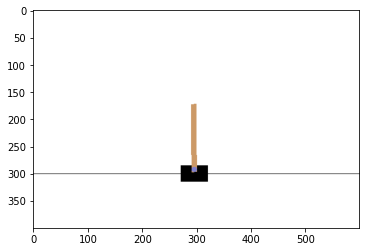

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"));

## Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [3]:
import torch
import torch.nn as nn


# YOUR CODE HERE
# Build a simple neural network that predicts policy logits.
# Hint: keep it simple. CartPole isn't worth deep architectures.
# model = nn.Sequential(...)
hidden_dim = 16
model = nn.Sequential(
    nn.Linear(state_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, n_actions),
)

## Predict function

Let's define function which will take states as input and return probabilities for actions.

> Note: input and output of this function are not a torch tensors, they're numpy arrays.

In [4]:
def predict_probs(state):
    # YOUR CODE HERE
    # Predict action probabilities given current state.
    # Note: state is a numpy array of shape [state_dim]
    # and return value should be a numpy array of shape [n_actions]
    # probs = ...
    state = torch.tensor(state[None, ...], dtype=torch.float32)
    with torch.no_grad():
        logits = model(state)[0]

    probs = torch.softmax(logits, dim=0).numpy()
    return probs

In [5]:
for _ in range(5):
    test_state = env.reset()
    test_probs = predict_probs(test_state)
    assert isinstance(
        test_probs, np.ndarray
    ), f"you must return np array and not {type(test_probs)}"
    assert tuple(test_probs.shape) == (n_actions,), f"wrong output shape: {test_probs.shape}"
    assert np.isclose(test_probs.sum(), 1), "probabilities do not sum to 1"

## Play the game

We can now use our newly built agent to play the game.

In [6]:
def generate_session(env, time_limit=1000):
    states, actions, rewards = [], [], []
    state = env.reset()

    for _ in range(time_limit):
        action_probs = predict_probs(state)

        # YOUR CODE HERE
        # Sample action with given probabilities.
        # action = ...
        action = np.random.choice(n_actions, p=action_probs)

        new_state, reward, done, _ = env.step(action)

        # record session history to train later.
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = new_state
        if done:
            break

    # Convert to numpy for faster to torch transformations.
    return np.array(states), np.array(actions), np.array(rewards)

In [7]:
# test it
states, actions, rewards = generate_session(env)

## Computing cumulative rewards

Now that we have our session's rewards, let's compute cumulative rewards for actions:

$$ G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots = r_t + \gamma G_{t+1} $$

In [8]:
def get_cumulative_rewards(rewards, gamma=0.99):
    # YOUR CODE HERE
    # Take a list of rewards for the whole session and compute cumulative rewards.
    # Note: you must return an array of cumulative rewards with as many elemnts as
    # in the initial one.
    # Hint: the simplest way would be to iterate from last reward to first and
    # compute G_t = r_t + gamma * G_{t+1} recurrently.
    # cumulative_rewards = ...
    cumulative_rewards = np.zeros_like(rewards, dtype=float)
    cumulative_rewards[-1] = rewards[-1]
    for i in reversed(range(len(rewards) - 1)):
        cumulative_rewards[i] = rewards[i] + gamma * cumulative_rewards[i + 1]

    return cumulative_rewards

In [9]:
assert isinstance(get_cumulative_rewards(rewards), np.ndarray)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0],
)
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0],
)
assert np.allclose(get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])

## Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

Which means that we can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [10]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    states = torch.tensor(states, dtype=torch.float32)  # shape: [batch_size, state_dim]
    actions = torch.tensor(actions, dtype=torch.long)  # shape: [batch_size]
    # cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    # cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)  # shape: [batch_size]
    cumulative_returns = torch.tensor(
        get_cumulative_rewards(rewards, gamma), dtype=torch.float32
    )  # shape: [batch_size]

    # Predict probas and log-probas using an agent.
    logits = model(states)
    probs = torch.softmax(logits, dim=1)
    log_probs = torch.log_softmax(logits, dim=1)

    # Select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = log_probs[range(states.shape[0]), actions]

    # YOUR CODE HERE
    # Compute loss here.
    # Don't forget entropy regularization with `entropy_coef`.
    # entropy = ...
    # loss = ...
    entropy = (probs * log_probs).sum()
    loss = (log_probs_for_actions * cumulative_returns).sum() + entropy_coef * entropy
    loss = -loss

    # Gradient descent step.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Return session rewards to print them later.
    return rewards.sum()

### The actual training

In [11]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]
    mean_reward = np.mean(rewards)
    print(f"mean reward: {mean_reward:.1f}")
    if mean_reward > 500:
        print("You Win!")
        break

mean reward: 24.6
mean reward: 29.2
mean reward: 44.9
mean reward: 56.0
mean reward: 120.9
mean reward: 192.9
mean reward: 320.7
mean reward: 354.9
mean reward: 562.5
You Win!


### Video

In [12]:
# Record sessions
import gym.wrappers


with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [13]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

## Bonus area: solving Acrobot-v1

Try to solve more complex environment using Policy gradient method.
*Hint: you will need add some imporovements to the original REINFORCE (e.g. Advantage Actor Critic or anything else).*

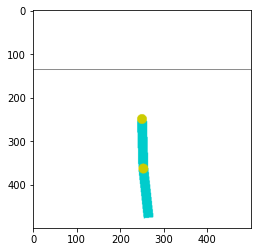

In [14]:
env = gym.make("Acrobot-v1")
env.reset()

plt.imshow(env.render("rgb_array"))
state_dim = env.reset().shape[0]
n_actions = env.action_space.n

In [15]:
# YOUR CODE HERE